## Import modules

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import bbknn


import celltypist
from celltypist import models

In [5]:
import session_info
session_info.show()

In [6]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu',)

## Function

## Read in data

batch_key: Donor + Nuclei_or_Cells + Kit_10X

In [7]:
adata_dir = '/nfs/team205/heart/anndata_objects/8regions'

In [8]:
adata = sc.read_h5ad(f'{adata_dir}/RNA_adult-8reg_raw_rmdblcls_celltype-annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 629041 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [9]:
genename_column='gene_name_multiome-2'

In [10]:
adata.X.data[:10]

array([1., 1., 1., 1., 2., 1., 1., 1., 5., 1.], dtype=float32)

In [11]:
adata.obs['cell_type'].value_counts()

Ventricular Cardiomyocyte     186428
Endothelial cell              122741
Fibroblast                    106672
Mural cell                     99845
Atrial Cardiomyocyte           40543
Myeloid                        37439
Lymphoid                       21178
Neuronal cell                   5625
Adipocyte                       5166
Mast cell                       1524
Lymphatic Endothelial cell       984
Mesothelial cell                 896
Name: cell_type, dtype: int64

## Add 'cell_state' column with combining 'cell_states_HCAv1' and 'cell_states_scNym'

In [12]:
compartments={
    'aCM':['Atrial Cardiomyocyte'], # include SAN P cell
    'vCM':['Ventricular Cardiomyocyte'],  # include AVN cell
    'EC':['Endothelial cell'],
    'LEC':['Lymphatic Endothelial cell'],
    'Mural':['Mural cell'],
    'Meso':['Mesothelial cell'],
    'FB':['Fibroblast'],
    'Adip':['Adipocyte'], 
    'NC':['Neuronal cell'], 
    # 'Myelo':['Myeloid'], # completely reannotated manually
    'Lymph':['Lymphoid'],
    'Mast':['Mast cell'],
}

# cell states belong to each cell type (not including P cells)
compartments_cellstates={
    'aCM':['aCM1','aCM2','aCM3','aCM4','aCM5'],
    'vCM':['vCM1','vCM2','vCM3','vCM4','vCM5'],
    'EC':['EC1_cap','EC2_cap','EC3_cap','EC4_immune','EC5_art','EC6_ven','EC7_atria','EC9_FB-like','EC10_CMC-like',],
    'LEC':['EC8_ln'],
    'Mural':['PC1_vent','PC2_atria','PC3_str','PC4_CMC-like','SMC1_basic','SMC2_art',],
    'Meso':['Meso'],
    'FB':['FB1','FB2','FB3','FB4','FB5','FB6',],
    'Adip':['Adip1','Adip2','Adip3','Adip4',], 
    'NC':['NC1','NC2','NC3','NC4','NC5','NC6',], 
    # 'Myelo':['Myeloid'], # reannotated manually
    'Lymph':['CD4+T_Tfh', 'CD4+T_Th1', 'CD4+T_Th2', 'CD4+T_Th17',
       'CD4+T_act', 'CD4+T_naive', 'CD4+T_reg', 'CD8+T_cytox', 'CD8+T_em',
       'CD8+T_te', 'CD8+T_trans', 'Cycling_T/NK', 'ILC', 'MAIT-like', 'NK_CD16hi',
       'NK_CD56hi', 'gdT','B','B_plasma'],
    'Mast':['Mast'],
}

In [13]:
adata.obs['cell_state']=adata.obs['cell_state_HCAv1'].astype('str').copy()

# take cell barcodes which doesn't have v1 annotation 
b=adata.obs_names[adata.obs['cell_state']!=adata.obs['cell_state']]

# add scNym transfered label to those cells
adata.obs.loc[b,'cell_state']=adata.obs.loc[b,'cell_state_scNym']

adata.obs['cell_state'].value_counts()

vCM1             98095
PC1_vent         55065
FB1              38749
vCM2             34849
EC1_cap          31894
                 ...  
NC4                 22
gdT                 21
NC6                 19
unclassfied.2       15
CD4+T_Th17           7
Name: cell_state, Length: 78, dtype: int64

In [14]:
# proportion of each cell state
df = pd.DataFrame(adata.obs['cell_state'].value_counts())
df.apply(lambda x: x/sum(x))

Note: NumExpr detected 60 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


,cell_state
vCM1,0.155944
PC1_vent,0.087538
FB1,0.061600
vCM2,0.055400
EC1_cap,0.050703
...,...
NC4,0.000035
gdT,0.000033
NC6,0.000030
unclassfied.2,0.000024


## Assign 'unclassified' cells

* rename as 'unclassified' if the cell_state is not in proper cell_type
* refer to compartments_cellstates dictionary above

In [15]:
for i, comp in enumerate(compartments.keys()):
    print(comp)
    
    sub_obs = adata.obs[adata.obs['cell_type']==compartments[comp][0]]
    
    # rename
    cellstate=['unclassified' if x not in compartments_cellstates[comp] else x for x in sub_obs['cell_state']]
    adata.obs.loc[sub_obs.index,'cell_state']=cellstate
    
    # generate cell label proportions dataframe
    df = pd.DataFrame(sub_obs['cell_state'].value_counts())
    df = df.apply(lambda x: x/sum(x))
    df.rename(columns={'cell_state':comp}, inplace=True)
    
    ## drop proper cell states from df
    df.drop(compartments_cellstates[comp], inplace=True)
    
    ## concatenate
    if i ==0:
        df_all = df.copy()
    else:
        df_all = pd.concat([df_all,df], axis=1)
    
    del sub_obs, df, cellstate, 

aCM
vCM
EC
LEC
Mural
Meso
FB
Adip
NC
Lymph
Mast


In [16]:
adata.obs[adata.obs['cell_state']=='unclassfied.2']

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,...,cluster_scrublet_score,doublet_pval,doublet_bh_pval,batch_key,leiden_scVI,cell_type,cell_state_HCAv1,cell_state_scNym,cell_state_scNym_confidence,cell_state
barcode,,,,,,,,,,,,,,,,,,,,,
HCAHeart7844001_CACCTTGGTAGCGCTC-1,HCAHeart7844001,na,D6,DCD,LA,LA,65-70,Male,Sanger,Cell,...,0.209877,0.029783,0.453551,D6_Cell_3prime-v2,24,Myeloid,unclassfied.2,nan,NaN,unclassfied.2
HCAHeart7850546_CGCCAAGAGCGACGTA,HCAHeart7850546,na,D7,DCD,RV,RV,60-65,Male,Sanger,Cell,...,0.149338,0.085394,0.814456,D7_Cell_3prime-v2,10,Myeloid,unclassfied.2,nan,NaN,unclassfied.2
H0035_LA_GCAGCCAGTTGGTACT,H0035_LA,na,H7,DBD,LA,LA,45-50,Female,Harvard,Nuclei,...,0.084225,0.546421,0.932102,H7_Nuclei_3prime-v3,24,Myeloid,unclassfied.2,nan,NaN,unclassfied.2


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  """


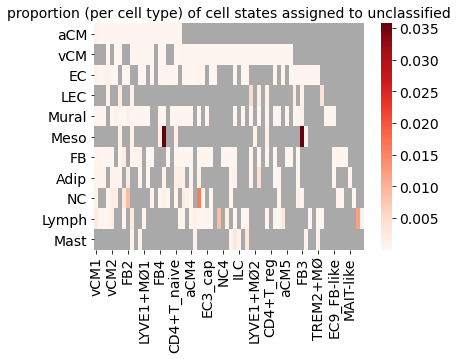

In [17]:
import seaborn as sns
import matplotlib as mpl
plt.rcParams['figure.figsize'] = 30,5
cmap = mpl.cm.get_cmap("Reds")
cmap.set_bad(color='darkgrey')
mask = df_all.T.isnull()
sns.heatmap(df_all.T, mask=mask, cmap=cmap)
plt.title('proportion (per cell type) of cell states assigned to unclassified')
plt.show()

In [18]:
# vCMs in RA/LA/SAN -> unclassified
# aCMs in RV/LV/SP/AX -> unclassified

## RA/LA/SAN
sub_obs = adata.obs[adata.obs['region'].isin(['RA','LA','SAN'])]
sub_obs = sub_obs[sub_obs['cell_state'].isin(['vCM1','vCM2','vCM3','vCM4','vCM5'])]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
del sub_obs

## RV/LV/SP/AX
sub_obs = adata.obs[adata.obs['region'].isin(['RV','LV','SP','AX'])]
sub_obs = sub_obs[sub_obs['cell_state'].isin(['aCM1','aCM2','aCM3','aCM4','aCM5'])]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
del sub_obs

'''
# aCMs in SAN -> unclassified -> add annotation later
# aCMs in AVN -> unclassified -> add annotation later
# vCMs in AVN -> unclassified -> add annotation later

## SAN
sub_obs = adata.obs[adata.obs['region'].isin(['SAN'])]
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte'])]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
del sub_obs

## AVN
sub_obs = adata.obs[adata.obs['region'].isin(['AVN'])]
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
del sub_obs
'''

"\n#\xa0aCMs in SAN -> unclassified -> add annotation later\n#\xa0aCMs in AVN -> unclassified -> add annotation later\n#\xa0vCMs in AVN -> unclassified -> add annotation later\n\n##\xa0SAN\nsub_obs = adata.obs[adata.obs['region'].isin(['SAN'])]\nsub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte'])]\nadata.obs.loc[sub_obs.index,'cell_state']='unclassified'\ndel sub_obs\n\n##\xa0AVN\nsub_obs = adata.obs[adata.obs['region'].isin(['AVN'])]\nsub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]\nadata.obs.loc[sub_obs.index,'cell_state']='unclassified'\ndel sub_obs\n"

In [19]:
adata.obs['cell_state'].value_counts()

vCM1             97800
PC1_vent         55029
FB1              38692
vCM2             34727
EC1_cap          31800
                 ...  
NC3                 20
NC6                 18
NC4                 13
CD4+T_Th17           7
unclassfied.2        3
Name: cell_state, Length: 79, dtype: int64

## Myeloid annotation

In [20]:
myel = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/scVI/subsets/Myelo_post-scVI_cellstates.h5ad')

myel.obs.replace({'cell_state':{
    'Doublet':'unclassified'
}},inplace=True)

myel.obs['cell_state'].value_counts()

LYVE1+IGF1+MP       13729
LYVE1+TIMD4+MP       6972
unclassified         4443
CD16+Mo              3767
CD14+Mo              3565
MoMP                 2525
LYVE1+MP_cycling     1447
DC                    874
Neut                  117
Name: cell_state, dtype: int64

In [21]:
# add new annotation
if all(adata.obs[adata.obs['cell_type']=='Myeloid'].index == myel.obs_names):
    adata.obs.loc[myel.obs_names,'cell_state']=myel.obs['cell_state'].astype('str')
else:
    print('ERROR: cell barcode are not same')

adata.obs[adata.obs['cell_type']=='Myeloid']['cell_state'].value_counts()

LYVE1+IGF1+MP       13729
LYVE1+TIMD4+MP       6972
unclassified         4443
CD16+Mo              3767
CD14+Mo              3565
MoMP                 2525
LYVE1+MP_cycling     1447
DC                    874
Neut                  117
Name: cell_state, dtype: int64

In [22]:
# modify 'Cycling_T/NK'
adata.obs.replace({'cell_state':{
    'Cycling_T/NK':'T/NK_cycling'
}}, inplace=True)

## SAN annotation

Object started as adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/scVI/subsets/aCM_post-scVI.h5ad')  then adata = adata[adata.obs['region'].isin(['SAN'])]

In [23]:
san = sc.read_h5ad('/nfs/team205/heart/JC_annotated_adata/SAN.h5ad')
san

AnnData object with n_obs × n_vars = 4883 × 28086
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', '_scvi_batch', '_scvi_labels', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'n_cells', 'gene_id'
    uns: '_scvi', 'age_colors', 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'dendrogram_leiden_0.2', 'donor_colors', '

In [24]:
# add SAN_P_cell annotation
sanP_obsname = san[san.obs['cell_state']=='SAN_P_cell'].obs_names
print(len(sanP_obsname))

adata.obs.loc[sanP_obsname,'cell_state']='SAN_P_cell'
sum(adata.obs['cell_state']=='SAN_P_cell')

47


47

In [25]:
pd.crosstab(adata.obs[adata.obs['region']=='SAN']['cell_state'],adata.obs[adata.obs['region']=='SAN']['cell_type'])

cell_type,Ventricular Cardiomyocyte,Atrial Cardiomyocyte,Fibroblast,Endothelial cell,Lymphatic Endothelial cell,Mural cell,Mesothelial cell,Neuronal cell,Adipocyte,Myeloid,Lymphoid,Mast cell
cell_state,,,,,,,,,,,,
Adip1,0,0,0,0,0,0,0,0,558,0,0,0
Adip2,0,0,0,0,0,0,0,0,203,0,0,0
Adip3,0,0,0,0,0,0,0,0,3,0,0,0
B,0,0,0,0,0,0,0,0,0,0,126,0
B_plasma,0,0,0,0,0,0,0,0,0,0,8,0
CD14+Mo,0,0,0,0,0,0,0,0,0,87,0,0
CD16+Mo,0,0,0,0,0,0,0,0,0,238,0,0
CD4+T_act,0,0,0,0,0,0,0,0,0,0,296,0
CD4+T_naive,0,0,0,0,0,0,0,0,0,0,358,0


In [26]:
# 'SAN_P_cell' in non-aCM cell type compartment -> unclassified
# nothing will change theoretically (if you think the way James subset data and annotate)
sub_obs = adata.obs[adata.obs['cell_state']=='SAN_P_cell']
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte'])==False]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(sum(adata.obs['cell_state']=='SAN_P_cell'))
del sub_obs

47


## AVN annotation

Object started as adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_celltype-annotated.h5ad')  then  adata = adata[adata.obs['region'].isin(['AVN'])] followed by adata = adata[adata.obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]

In [30]:
avn = sc.read_h5ad('/nfs/team205/heart/JC_annotated_adata/AVN_v4.h5ad')
avn

AnnData object with n_obs × n_vars = 11264 × 3277
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'hvg', 'kit_10x_colors', 'leiden_scVI_colors', 'neighbors', 'pca', 'rank_genes_groups', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', '

In [31]:
pd.crosstab(avn.obs['cell_state'],avn.obs['cell_state_scNym']).T

cell_state,AVN_P_cell,AVN_bundle_cell,Atrial Cardiomyocyte,Ventricular Cardiomyocyte
cell_state_scNym,,,,
B_plasma,0,0,0,1
EC1_cap,0,0,0,2
EC2_cap,0,0,0,1
EC8_ln,0,0,0,1
EC10_CMC-like,0,2,1,2
FB4,0,0,0,2
FB5,0,0,0,1
FB6,0,7,0,0
ILC,0,0,0,2


In [32]:
# add AVN_P_cell annotation
avnP_obsname = avn[avn.obs['cell_state']=='AVN_P_cell'].obs_names
print(len(avnP_obsname))

adata.obs.loc[avnP_obsname,'cell_state']='AVN_P_cell'
sum(adata.obs['cell_state']=='AVN_P_cell')

154


154

In [33]:
# add AVN_bundle_cell annotation
avn_bundle_obsname = avn[avn.obs['cell_state']=='AVN_bundle_cell'].obs_names
print(len(avn_bundle_obsname))

adata.obs.loc[avn_bundle_obsname,'cell_state']='AVN_bundle_cell'
sum(adata.obs['cell_state']=='AVN_bundle_cell')

42


42

In [34]:
# 'SAN_P_cell' in non-aCM|vCN cell type compartment -> unclassified
sub_obs = adata.obs[adata.obs['cell_state']=='AVN_P_cell']
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])==False]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(sum(adata.obs['cell_state']=='AVN_P_cell'))
del sub_obs

# 'AVN_bundle_cell' in non-aCM|vCM cell type compartment -> unclassified
sub_obs = adata.obs[adata.obs['cell_state']=='AVN_bundle_cell']
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])==False]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(sum(adata.obs['cell_state']=='AVN_bundle_cell'))
del sub_obs

154
42


## Plotting

In [35]:
adata.obs['cell_state']=adata.obs['cell_state'].astype('category')
adata.obs['cell_state'].cat.reorder_categories([
    'aCM1','aCM2', 'aCM3', 'aCM4', 'aCM5', 'SAN_P_cell','AVN_P_cell','AVN_bundle_cell',
    'vCM1', 'vCM2', 'vCM3', 'vCM4', 'vCM5', 
     'EC1_cap','EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_atria',
       'EC8_ln', 'EC9_FB-like', 'EC10_CMC-like', 
    'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic', 'SMC2_art',
    'FB1', 'FB2', 'FB3', 'FB4','FB5', 'FB6',
    'Meso',
    'Adip1', 'Adip2', 'Adip3', 'Adip4',
    'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6',
    'CD4+T_naive', 'CD4+T_act','CD4+T_Th1', 'CD4+T_Th2', 'CD4+T_Th17', 'CD4+T_Tfh',
       'CD4+T_reg', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans','MAIT-like','gdT', 
    'NK_CD16hi', 'NK_CD56hi', 'ILC', 
     'B', 'B_plasma', 
    'CD14+Mo',  'CD16+Mo', 'MoMP',
    'LYVE1+IGF1+MP','LYVE1+TIMD4+MP', 'DC','Neut','Mast',
    'T/NK_cycling','LYVE1+MP_cycling', 'unclassified',
    
     ], inplace=True)

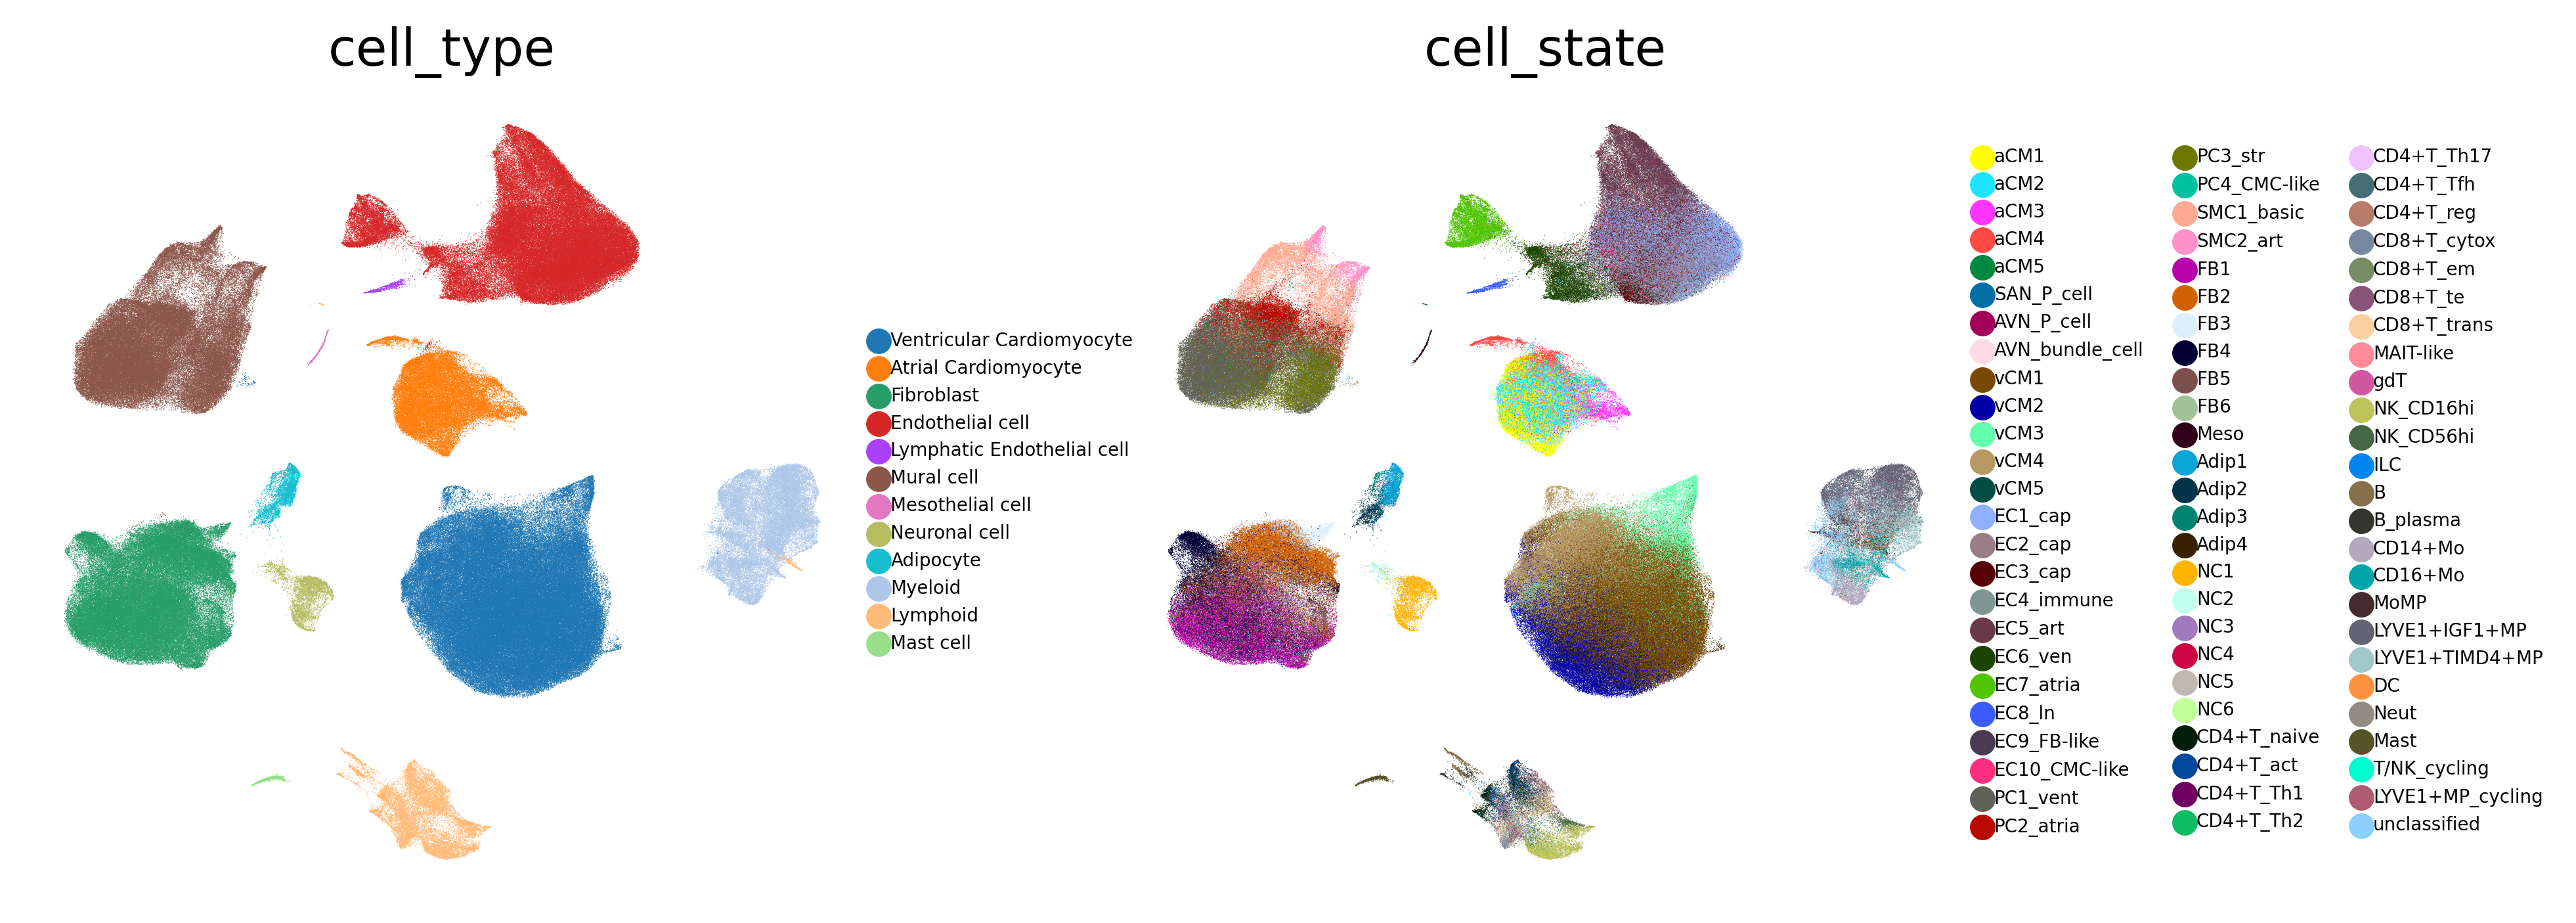

In [36]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)
sc.pl.umap(adata, color=['cell_type','cell_state'], legend_fontsize=5, frameon=False,
          # legend_loc='on data', 
          )

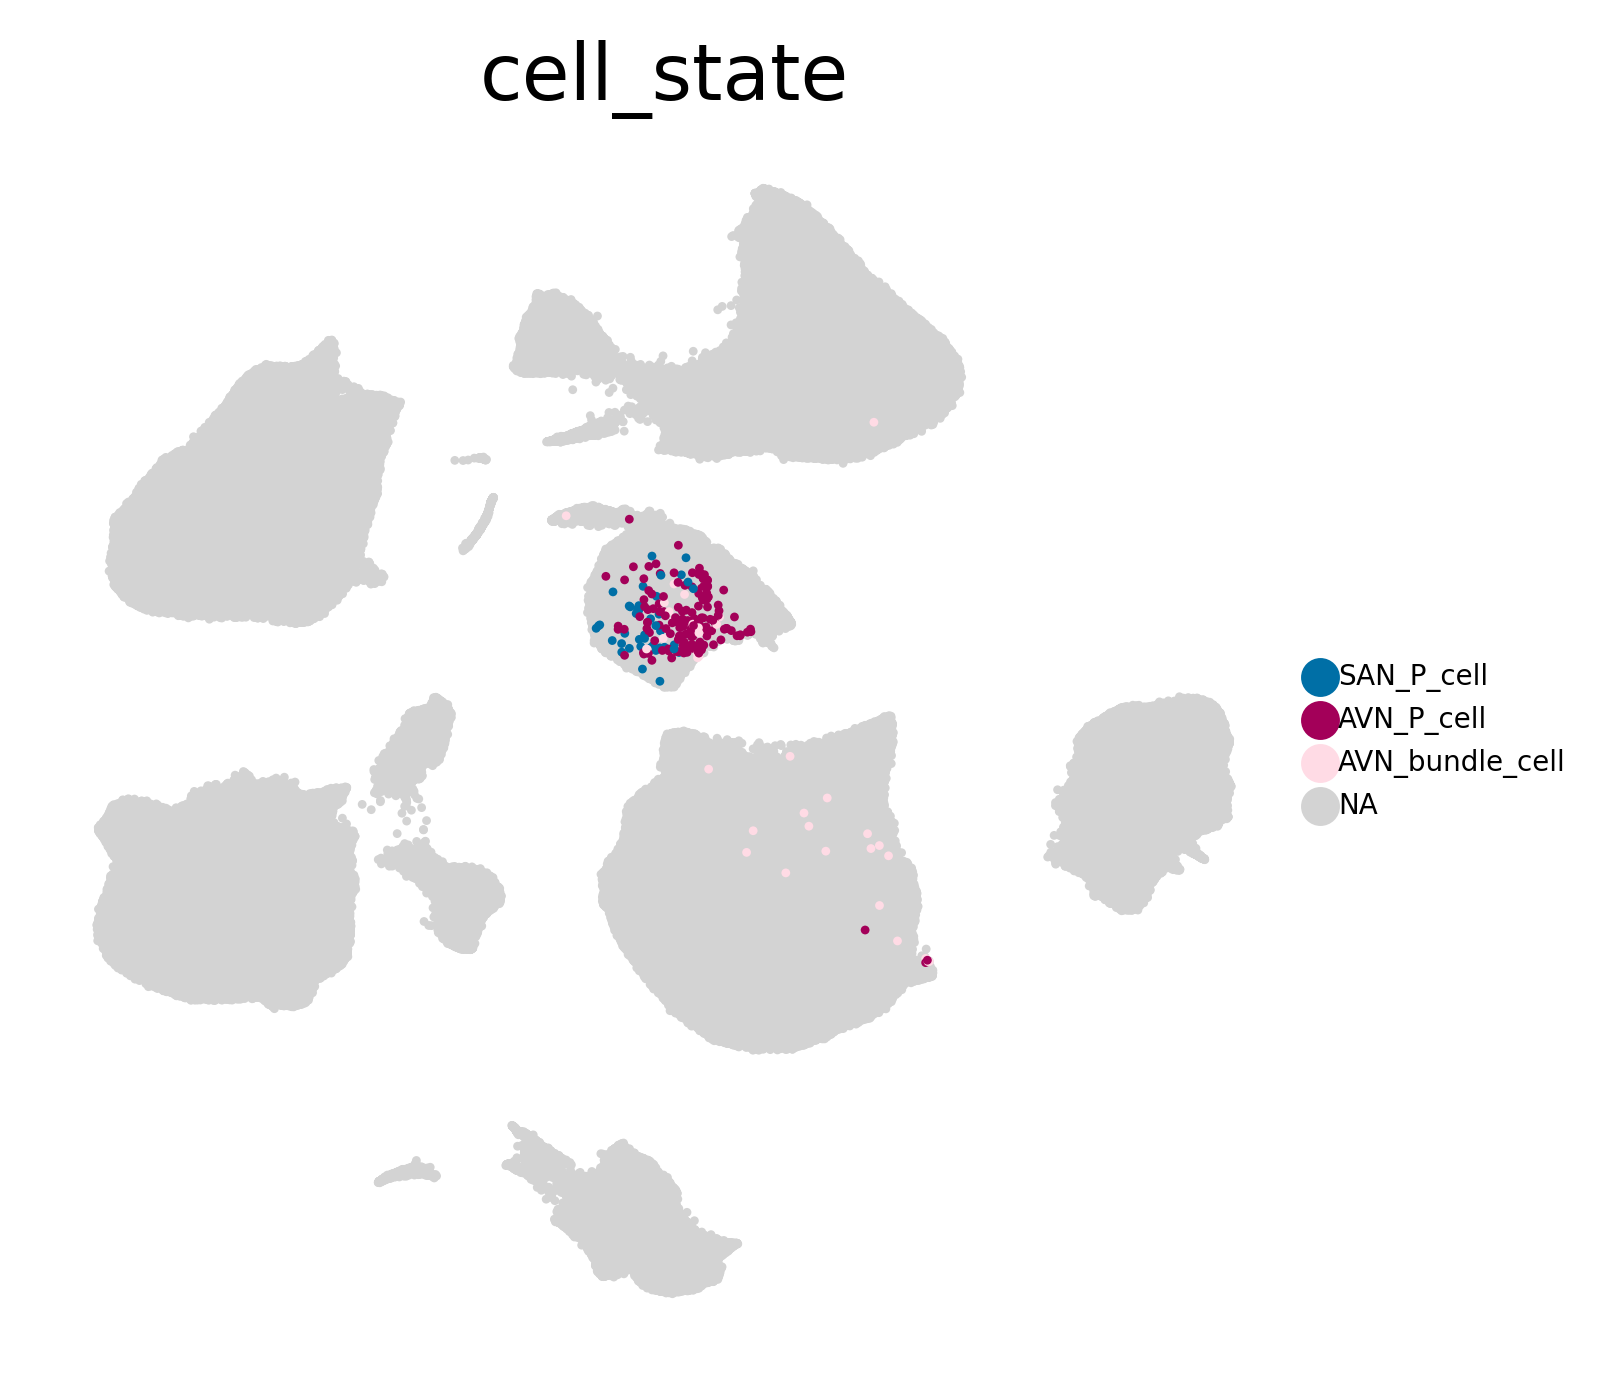

In [37]:
sc.pl.umap(adata, color='cell_state', groups=['SAN_P_cell','AVN_P_cell','AVN_bundle_cell',], legend_fontsize=5, frameon=False,size=10)

In [38]:
adata.X.data[:10]

array([1., 1., 1., 1., 2., 1., 1., 1., 5., 1.], dtype=float32)

`drug2cell`

## Save

In [39]:
adata.write(f'{adata_dir}/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad')

In [40]:
f'{adata_dir}/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad'

'/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad'

## marker checking

In [46]:
test = adata.copy()
sc.pp.filter_genes(test, min_cells=3)
sc.pp.normalize_total(test, target_sum=1e4)
sc.pp.log1p(test)
test

AnnData object with n_obs × n_vars = 629041 × 31141
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2', 'n_cells'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors', 'cell_state_colors', 'log1p'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [47]:
test.var_names=test.var[genename_column]
test.var_names=test.var_names.astype('str')
test.var_names_make_unique()

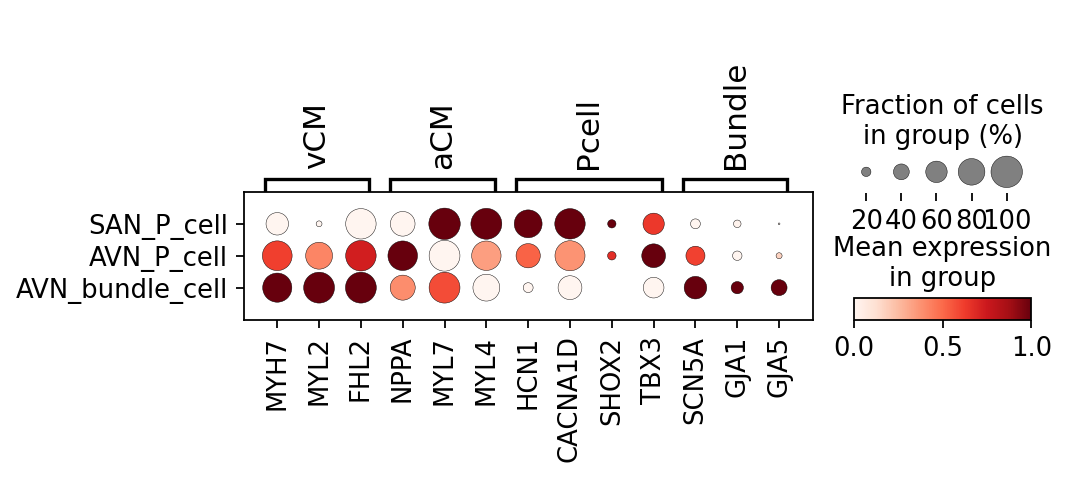

In [48]:
markers = {
    'vCM': ['MYH7', 'MYL2', 'FHL2'],
    'aCM': ['NPPA', 'MYL7', 'MYL4'],
    'Pcell': ['HCN1', 'CACNA1D', 'SHOX2', 'TBX3'],
    'Bundle': ['SCN5A', 'GJA1', 'GJA5'],
}


for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in test.var_names]

sc.pl.dotplot(test[test.obs['cell_state'].isin(['SAN_P_cell','AVN_P_cell','AVN_bundle_cell'])],
              markers, 
              groupby='cell_state',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              # swap_axes=True,
             )

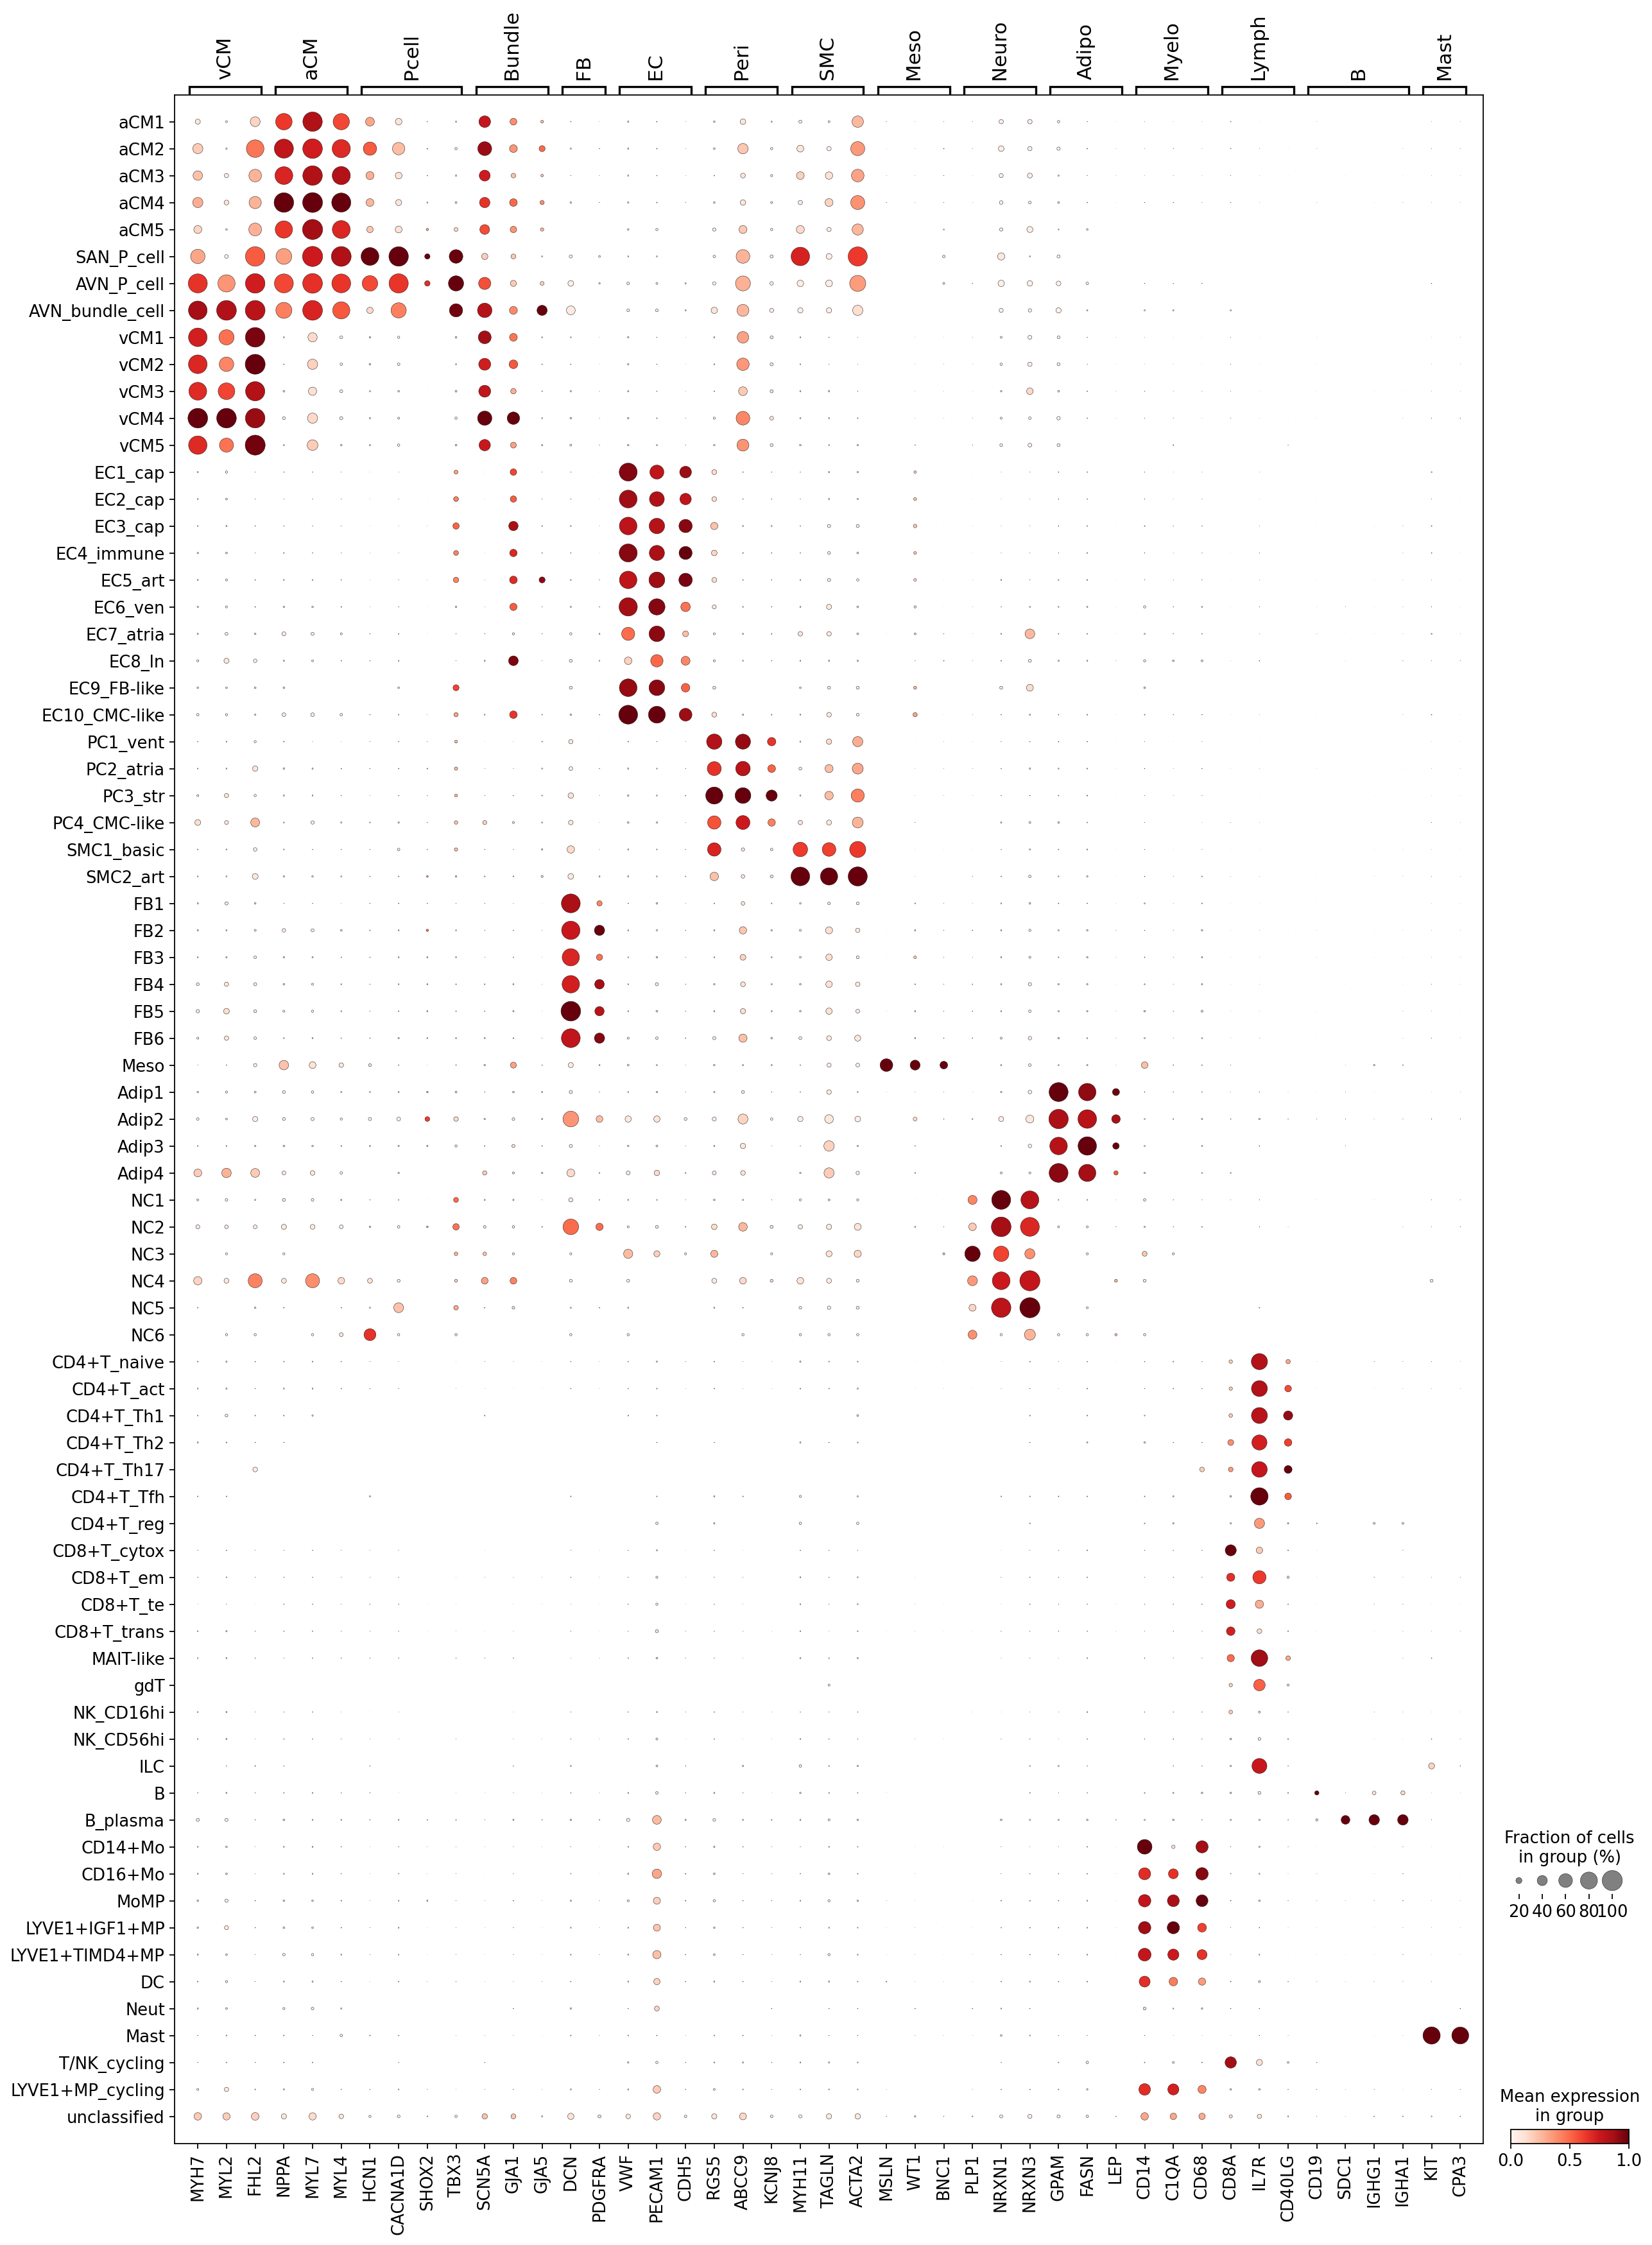

In [49]:
markers = {
    'vCM': ['MYH7', 'MYL2', 'FHL2'],
    'aCM': ['NPPA', 'MYL7', 'MYL4'],
    'Pcell': ['HCN1', 'CACNA1D', 'SHOX2', 'TBX3'],
    'Bundle': ['SCN5A', 'GJA1', 'GJA5'],
    'FB': ['DCN', 'GCN', 'PDGFRA'],
    'EC': ['VWF', 'PECAM1', 'CDH5'],
    'Peri': ['RGS5', 'ABCC9', 'KCNJ8'],
    'SMC': ['MYH11', 'TAGLN', 'ACTA2'],
    'Meso': ['MSLN', 'WT1', 'BNC1'],
    'Neuro': ['PLP1', 'NRXN1', 'NRXN3'],
    'Adipo': ['GPAM', 'FASN', 'LEP'],
    'Myelo': ['CD14', 'C1QA', 'CD68'],
    'Lymph': ['CD8A', 'IL7R', 'CD40LG'],
    'B': ['CD19','SDC1','IGHG1','IGHA1'],
    'Mast': ['KIT', 'CPA3'],
}


for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in test.var_names]

sc.pl.dotplot(test,
              markers, 
              groupby='cell_state',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              # swap_axes=True,
             )